In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

%matplotlib inline

In [4]:
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


# Least Absolute Deviation
Median model (q = 0.5)

In [5]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=0.5)
res.summary()

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)
/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Tue, 13 Nov 2018   No. Observations:                  235
Time:                        08:24:22   Df Residuals:                      233
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586
==============================================================================

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
quantiles = np.arange(0.05, 0.96, 0.1)

In [13]:
def fit_model(q):
    res = mod.fit(q=q)
    return ([q, res.params['Intercept'], res.params['income']] 
            + res.conf_int().loc['income'].tolist())

In [16]:
models = [fit_model(q) for q in quantiles]
models = pd.DataFrame(
    models, columns=['q', 'intercept', 'income', 'lower', 'upper'])

models

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,q,intercept,income,lower,upper
0,0.05,124.880098,0.343361,0.268632,0.418090
1,0.15,111.693660,0.423708,0.382780,0.464636
2,0.25,95.483539,0.474103,0.439900,0.508306
3,0.35,105.841294,0.488901,0.457759,0.520043
4,0.45,81.083647,0.552428,0.525021,0.579835
5,0.55,89.661370,0.565601,0.540955,0.590247
6,0.65,74.033436,0.604576,0.582169,0.626982
7,0.75,62.396584,0.644014,0.622411,0.665617
8,0.85,52.272216,0.677603,0.657383,0.697823
9,0.95,64.103964,0.709069,0.687831,0.730306


In [17]:
ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = {'intercept': ols.params['Intercept'],
       'income': ols.params['income'],
       'lower': ols_ci[0],
       'upper': ols_ci[1]}
ols

{'intercept': 147.47538852370573,
 'income': 0.48517842367692354,
 'lower': 0.4568738130184233,
 'upper': 0.5134830343354237}

In [21]:
x = np.arange(0, data.income.max(), 50)
get_y = lambda a, b: a + b*x

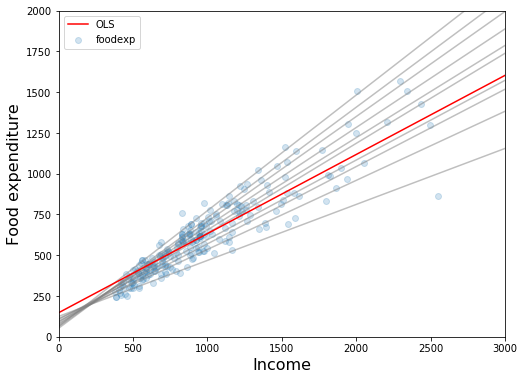

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(models.shape[0]):
    y = get_y(models.intercept[i], models.income[i])
    ax.plot(x, y, color='grey', alpha=0.5)
    
y = get_y(ols['intercept'], ols['income'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=0.2)
ax.set_xlim([0, 3000])
ax.set_ylim([0, 2000])
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);

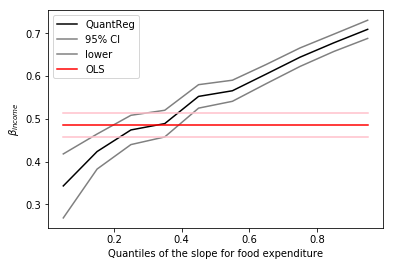

In [26]:
n = models.shape[0]

plt.plot(models.q, models.income, color='k', label='QuantReg')
plt.plot(models.q, models.upper, color='grey', label='95% CI')
plt.plot(models.q, models.lower, color='grey', label=None)

plt.plot(models.q, [ols['income']] * n, color='r', label='OLS')
plt.plot(models.q, [ols['upper']] * n, color='pink', label=None)
plt.plot(models.q, [ols['lower']] * n, color='pink', label=None)
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the slope for food expenditure')
plt.legend();